In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
# loading the data
df = pd.read_csv('../../data/LSTMGames.csv')

In [3]:
df.head(10)

,SEASON,GAME_DATE,TEAM_ID,FGM_DIFF,FGA_DIFF,FG3M_DIFF,FTM_DIFF,FTA_DIFF,OREB_DIFF,DREB_DIFF,AST_DIFF,STL_DIFF,TOV_DIFF,PF_DIFF,PTS_DIFF,WIN,HOME_GAME
0,2002,2002-10-30,1610612737,-3.0,-3,2,-7.0,-7.0,-6,-7,-3,5,3,4.0,-11,0,0
1,2002,2002-10-31,1610612737,6.0,-1,-1,-4.0,-3.0,-2,5,3,-3,2,2.0,7,1,1
2,2002,2002-11-02,1610612737,-1.0,-12,1,7.0,5.0,0,4,10,-8,9,-5.0,6,1,1
3,2002,2002-11-05,1610612737,8.0,-7,2,-2.0,-5.0,-3,13,8,3,6,7.0,16,1,0
4,2002,2002-11-06,1610612737,-2.0,-2,0,-1.0,1.0,6,3,-9,2,5,3.0,-5,0,0
5,2002,2002-11-08,1610612737,-6.0,-11,6,-7.0,-15.0,-10,-8,-17,1,4,4.0,-13,0,0
6,2002,2002-11-10,1610612737,-3.0,-5,-2,0.0,-4.0,-1,4,-2,-3,7,2.0,-8,0,0
7,2002,2002-11-12,1610612737,0.0,-20,-1,13.0,13.0,-8,16,-5,-8,8,-3.0,12,1,0
8,2002,2002-11-16,1610612737,0.0,-18,1,6.0,11.0,-6,13,6,-2,5,-1.0,7,1,1
9,2002,2002-11-18,1610612737,17.0,19,-3,-6.0,-12.0,4,5,13,-5,-6,0.0,25,1,1


In [4]:
split_fraction = 0.70
#train_split = int(split_fraction * int(df.shape[0]))
step = 1
past = 14
future = 0
learning_rate = 0.001
batch_size = 32
epochs = 100

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


In [5]:
# Create split by team
#inputs = np.array([])

team_list = pd.unique(df['TEAM_ID'])

# Create None type for dataset
combined_dataset_train = None
combined_dataset_val = None

for team_id in team_list:
    team_df = df[df['TEAM_ID'] == team_id]
    
    team_features = team_df.iloc[:,3:(team_df.shape[1]-1)]
    team_features.index = team_df['GAME_DATE']
    team_train_split = int(split_fraction * int(team_df.shape[0]))
    
    # For now we are normalizing per team
    #features = normalize(team_features.values, team_train_split)
    team_features = pd.DataFrame(team_features.values)
    
    train_data = team_features.loc[0 : team_train_split - 1]
    val_data = team_features.loc[team_train_split:]
    
    # Create Training Dataset
    start = past + future
    end = start + team_train_split

    x_train = train_data[[i for i in range(13)]].values
    y_train = team_features.iloc[start:end][[12]]

    sequence_length = int(past / step)
    
    dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

    x_end = len(val_data) - past - future

    # Validation Dataset now
    label_start = team_train_split + past + future

    x_val = val_data.iloc[:x_end][[i for i in range(13)]].values
    y_val = team_features.iloc[label_start:][[12]]

    dataset_val = keras.preprocessing.timeseries_dataset_from_array(
        x_val,
        y_val,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=batch_size,
    )

    if combined_dataset_train is None:
        combined_dataset_train = dataset_train
        combined_dataset_val = dataset_val
    else:
        combined_dataset_train = combined_dataset_val.concatenate(dataset_train)
        combined_dataset_val = combined_dataset_val.concatenate(dataset_val) 
    
    

2022-12-07 10:42:55.676718: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-07 10:42:55.676840: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [6]:
for batch in combined_dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 14, 13)
Target shape: (32, 1)


2022-12-07 10:42:57.391440: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [7]:
# Use Keras LSTM layer to consruct a model
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32,dropout=0.2)(inputs)
outputs = keras.layers.Dense(1, activation='sigmoid')(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="binary_crossentropy", metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 13)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                5888      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,921
Trainable params: 5,921
Non-trainable params: 0
_________________________________________________________________


In [8]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", min_delta=0, patience=20)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_binary_accuracy",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    combined_dataset_train,
    epochs=epochs,
    validation_data=combined_dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/100


2022-12-07 10:42:58.746774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-07 10:42:58.914373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/404 [..............................] - ETA: 8:15 - loss: 0.6632 - binary_accuracy: 0.5938

2022-12-07 10:42:59.073592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


403/404 [============================>.] - ETA: 0s - loss: 0.6916 - binary_accuracy: 0.5463

2022-12-07 10:43:06.634056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-07 10:43:06.693303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_binary_accuracy improved from -inf to 0.57276, saving model to model_checkpoint.h5
404/404 [==============================] - 12s 26ms/step - loss: 0.6916 - binary_accuracy: 0.5464 - val_loss: 0.6785 - val_binary_accuracy: 0.5728
Epoch 2/100
401/404 [============================>.] - ETA: 0s - loss: 0.6752 - binary_accuracy: 0.5788
Epoch 2: val_binary_accuracy improved from 0.57276 to 0.58138, saving model to model_checkpoint.h5
404/404 [==============================] - 8s 19ms/step - loss: 0.6751 - binary_accuracy: 0.5788 - val_loss: 0.6736 - val_binary_accuracy: 0.5814
Epoch 3/100
402/404 [============================>.] - ETA: 0s - loss: 0.6666 - binary_accuracy: 0.5936
Epoch 3: val_binary_accuracy improved from 0.58138 to 0.58509, saving model to model_checkpoint.h5
404/404 [==============================] - 8s 20ms/step - loss: 0.6665 - binary_accuracy: 0.5938 - val_loss: 0.6719 - val_binary_accuracy: 0.5851
Epoch 4/100
402/404 [============================>.] - ETA

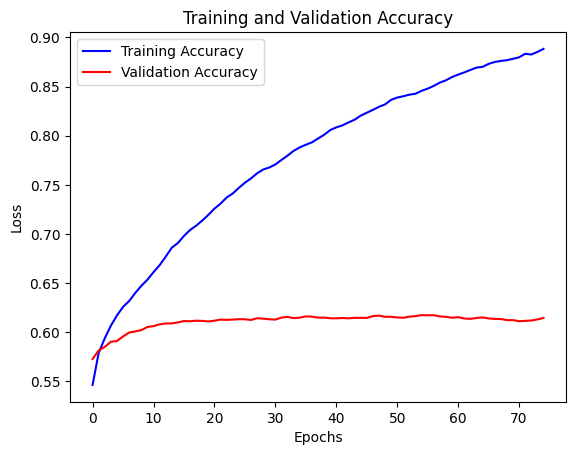

In [11]:

def visualize_loss(history, title):
    accuracy = history.history["binary_accuracy"]
    val_accuracy = history.history["val_binary_accuracy"]
    epochs = range(len(accuracy))
    plt.figure()
    plt.plot(epochs, accuracy, "b", label="Training Accuracy")
    plt.plot(epochs, val_accuracy, "r", label="Validation Accuracy")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Accuracy")

In [10]:
for x,y in dataset_val.take(1):
    print(model.predict(x)[2])
    print(y[2])

1/1 [==============================] - 0s 251ms/step
[0.8348124]
tf.Tensor([1.], shape=(1,), dtype=float64)


2022-12-07 10:53:16.038486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-07 10:53:16.091324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
